In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

from scipy.spatial.distance import cdist
import re

import string 
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /home/sneha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# reading text file to a data frame

In [84]:
df = pd.read_csv('mlsp q4 data.txt', delimiter='\t', quoting=csv.QUOTE_NONNUMERIC, header = None, names=['Review','Labels'])
df['Labels'] = df['Labels'].apply(np.int32)
df[17:26]

,Review,Labels
17,Ill put this gem up against any movie in terms...,1
18,Its practically perfect in all of them true m...,1
19,The structure of this film is easily the most...,1
20,I can think of no other film where something v...,1
21,In other words the content level of this film ...,1
22,How can anyone in their right mind ask for any...,1
23,Its quite simply the highest most superlative ...,1
24,Yes this film does require a rather significan...,1
25,This short film certainly pulls no punches,0


# removing  labels

In [85]:
text=df['Review']
Label=df['Labels']

In [86]:
stop= set(stopwords.words('english'))  #set of stopwords in english


# data pre-processing
 removal of stop words 

In [87]:
# list of all n reviews(documents)
corpus = []  
# list of all unique words 
unique_words= []                                                                      
#for giving all unique word some index for the tf-idf vector 
word_index={}
ind=0;
for sentence in text.values:
      #removing special character by keeping only alphabets
      sentence = re.sub(pattern='[^a-zA-Z]',repl=' ', string=sentence)   
      #tokenisation of words
      doc = sentence.lower().split()    
      #removing stop words from the document
      doc = [word for word in doc if not word in set(stop)]  
      corpus.append(doc) 
      #creating array of all unique words
      for word in doc:                                                              
          if word not in unique_words:                                                   
                unique_words.append(word)  
                word_index[word]=ind
                ind+=1


#corpus

# computing avg TF_IDF feature for each review

# step 1: calculating term frequency


In [88]:
def TF(document, word):
    N = len(document)
    boolval= (document==word)
    tf = (len([dword for dword in document if dword== word]))/N
 
    return tf

# step 2: calculating word frequency in all documents

In [89]:
                                                         
    word_count = {}                                      
    for word in unique_words:
        word_count[word] = 0                            
        for document in corpus:
            if word in document:
                word_count[word] += 1
    

# step 3: IDF calculation

In [90]:
def IDF(word):
    
    word_freq = word_count[word]+1 # so that it never become zero 
    return np.log(1000/word_freq)              
    


# step 4: TF-IDF calculation

In [91]:
def TF_IDF(document):
    
    tfidf_vec = np.zeros((len(unique_words)))
    
    for word in document:
        
        tf_idf = TF(document,word)*IDF(word)
        tfidf_vec[word_index[word]] = tf_idf
    
    return tfidf_vec

# step 5: creating TF-IDF vector for each review/document

In [92]:
                           
feature_vectors= []

for document in corpus:
    feature_vectors.append(TF_IDF(document))
 
print(len(feature_vectors), len(feature_vectors[0]))

1000 2964


# PCA dimension reduction to 10 features

In [93]:
# directly applying PCA function available in sklearn
pca= PCA(n_components= 10)
pca.fit(feature_vectors)
final_data= pca.transform(feature_vectors)
final_data=np.array(final_data)

norm_data = preprocessing.normalize(final_data)
#data standarization
std_data = StandardScaler().fit_transform(final_data)
final_data=norm_data


# plotting original data on first 2 PCA dimensions

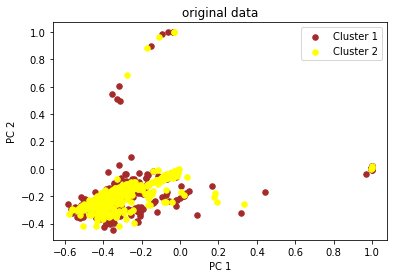

In [94]:
#plt.scatter(std_data[:,0],std_data[:,1], s = 5, c = 'red')
#plt.scatter(norm_data[:,0],norm_data[:,1], s = 5, c = 'red')
cluster1=final_data[Label==1]
cluster2=final_data[Label==0]
        
plt.scatter(cluster1[:,0], cluster1[:,1], s = 30, c = 'brown', label = 'Cluster 1')
plt.scatter(cluster2[:,0], cluster2[:, 1], s = 30, c = 'yellow', label = 'Cluster 2')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('original data')
plt.legend()
plt.show()



# training 2 mixture gaussian model

In [95]:
N=1000
D=10
K=2
mean = np.zeros((K,D))
sigma = np.zeros((K,D,D))
alpha = np.zeros((K))
Z= np.zeros((N,K))


# randomly assigning posterier probability of mixture component k given the data point xn
lets denote it as Znk


In [96]:

for i in range(N):    
    j=np.random.randint(0, K)
    Z[i][j]=1


# calculating randomly initialised parameter

In [104]:
def total_sigma(Z,mean,weight):
    
    sigma = np.zeros((K,D,D))
    for k in range(K):
        for i in range(N):
        
            diff = (final_data[i]-mean[k]).reshape(1,D)
            sigma[k] += Z[i,k] * np.dot(diff.T, diff)
        
        sigma[k] /= weight[k]
        
    return sigma 
    

In [105]:
def diag_sigma(Z,mean,weight):
    
    sigma = np.zeros((K,D,D))
    for k in range(K):
        sigmaTemp=np.zeros((1,D))
        for i in range(N):
        
            diff = ((final_data[i]-mean[k])**2).reshape(1,D)
            
            sigmaTemp += Z[i,k] * diff
            #print(sigmaTemp)
        
        sigmaTemp /= weight[k]
       
        sigma[k]=np.diag(sigmaTemp.reshape(D,))
    

    
       
    return sigma 
    

In [106]:
# weight=np.sum(Z,axis=0)
# alpha=weight/N

# mean = (np.dot(final_data.T,Z)/weight).T  
# sigma=diag_sigma(Z,mean,weight)




# initializing parameter using KMEANS

In [108]:
def KMEANS(X,k):

    row,col=X.shape
   
    #initiating centers randomly
    np.random.seed(4160659)
    centers = X[np.random.choice(row, k, replace=False)]
    
    closest = np.zeros(row).astype(int)
    count=20
    while True:
        old_closest = closest.copy()
        # calculating distance of each point from the center
        distances = cdist(X, centers)
        #calculating closest center for each data point
        closest = np.argmin(distances, axis=1)
    
        #updating centers
        for i in range(k):
            centers[i, :] = X[closest == i].mean(axis=0)
        #if conversion occurs    
        count-=1
        if all(closest == old_closest  ):
                break
    
    return centers, closest
  
    return 0

In [109]:
def KMEAN_INIT(X,K, flag=False):
    N,D=X.shape
    mean,closest=KMEANS(X,K)
#     kmeans = KMeans(n_clusters=K, init='k-means++', 
#                 max_iter=500, n_init=1, verbose=0, random_state=1240).fit(X)
#     mean=kmeans.cluster_centers_
#     closest = kmeans.labels_

    sigma = np.zeros((K,D,D))
    alpha = np.zeros((K))
    Z= np.zeros((N,K))

    for i in range(N):    
    
        Z[i][closest[i]]=1

    weight=np.sum(Z,axis=0)
    alpha=weight/N
    
    if(flag==True):
        sigma = total_sigma(Z,mean,weight)
    else:
        sigma = diag_sigma(Z,mean,weight)
        
        
    return (mean, alpha,sigma,Z)


In [110]:
mean,alpha,sigma,Z= KMEAN_INIT(final_data,K,True)
    


# multivariate gaussian probability


In [111]:
def Prob_Gaussian(x,mean,sigma):
   
    sig_inv = np.linalg.inv(sigma)
    
    temp=-1 * 0.5 * np.matmul(np.matmul((x-mean).T,sig_inv),(x-mean))
    
    exponent = np.exp(temp)
    
    prob = exponent/np.sqrt(np.power(2*np.pi,D)*np.linalg.det(sigma))
    
    return prob

# expectation function

In [112]:
def E_step(alpha,mean,sigma):
    
    for n in range(N):
        for k in range(K):
           
            prob = Prob_Gaussian(final_data[n], mean[k], sigma[k])    
            
            Z[n,k] = alpha[k] * prob
        
        Z[n] /= np.sum(Z[n])
        
                    
    return Z

# M-Step

In [113]:
def M_step(Z):
    
    weight = np.sum(Z, axis=0) 
    
    alpha = weight/ N
    
    mean = (np.dot(final_data.T,Z)/weight).T
    
    sigma = total_sigma(Z,mean,weight)
    
    return alpha,mean,sigma    

# likelihood function

In [114]:
def likelihood(X, Z, alpha, mean, sigma):
    LL=0  
    sum = 0
    
    for n in range(N): 
        sum=0
        for k in range(K):
            
            sum += alpha[k] * Prob_Gaussian(X[n], mean[k], sigma[k])
            
        LL+=np.log(sum)
        sum=0
    
    return LL

# function to show scatter plot

In [115]:
def scatter_plot(Z,count):
    cluster= np.zeros(N)

    for i in range(N):
         if Z[i][1]>Z[i][0] :                          
                cluster[i] =1  
    cluster1=final_data[cluster==1]
    cluster2=final_data[cluster==0]
        
    plt.scatter(cluster1[:,0], cluster1[:,1], s = 30, c = 'brown', label = 'Cluster 1')
    plt.scatter(cluster2[:,0], cluster2[:, 1], s = 30, c = 'yellow', label = 'Cluster 2')
    plt.xlabel('PC 1')
    plt.ylabel('PC 2')
    plt.title('Iteration {} '.format(count))
    plt.legend()
    plt.show()


# EM iteration

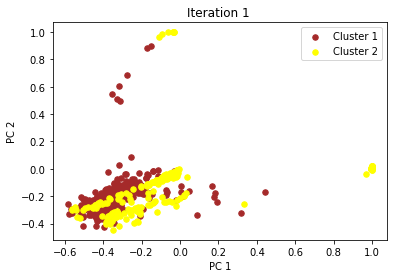

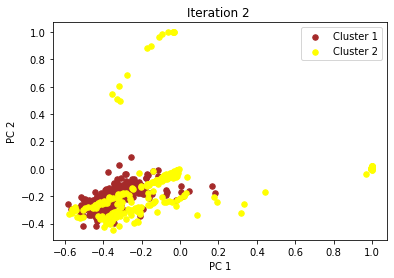

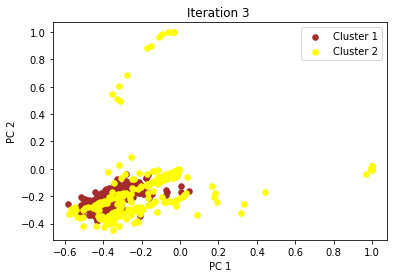

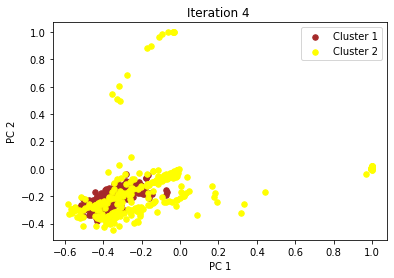

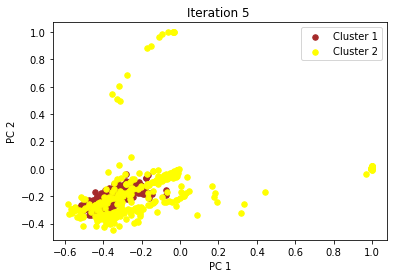

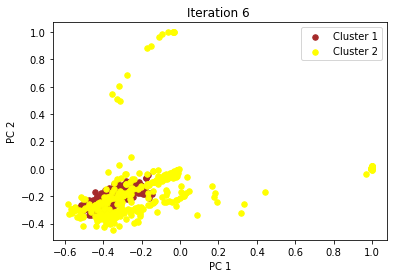

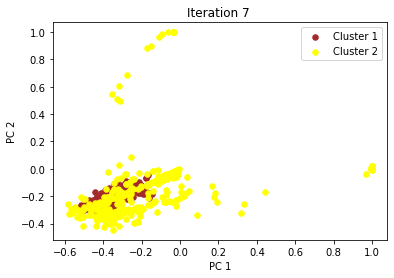

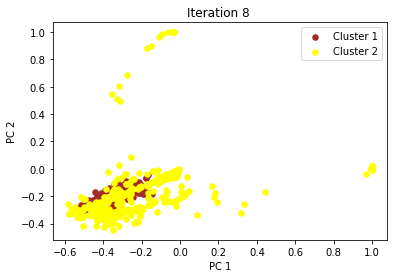

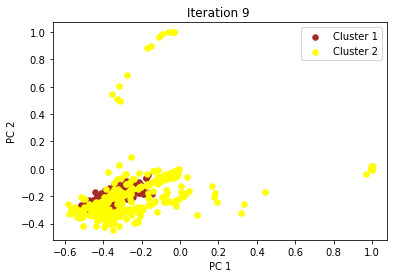

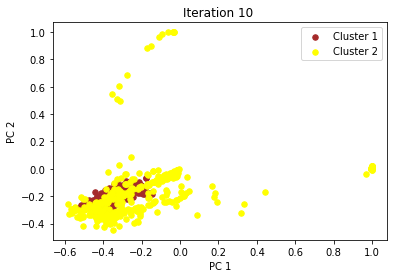

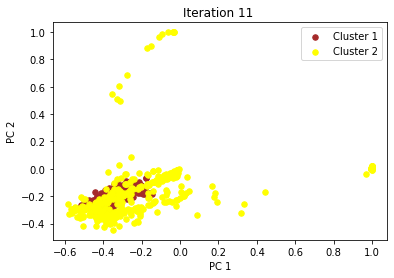

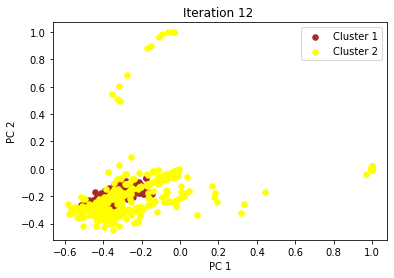

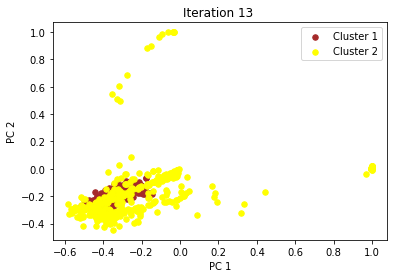

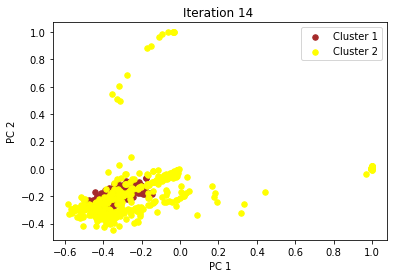

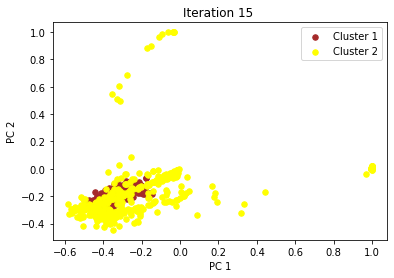

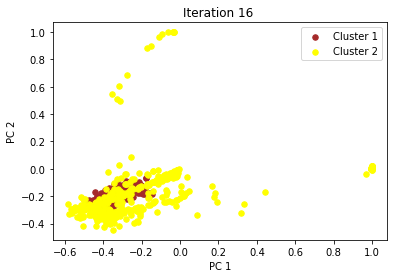

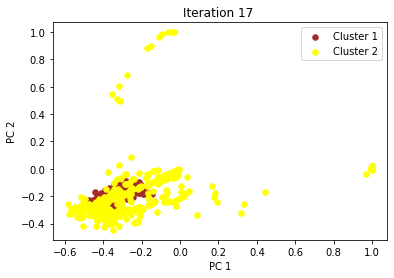

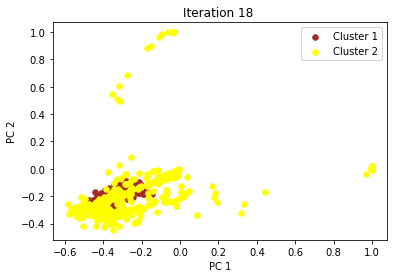

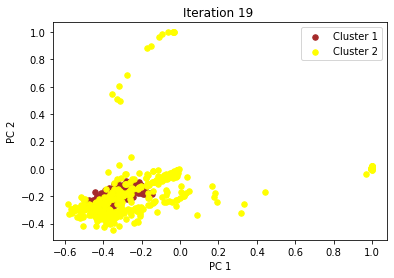

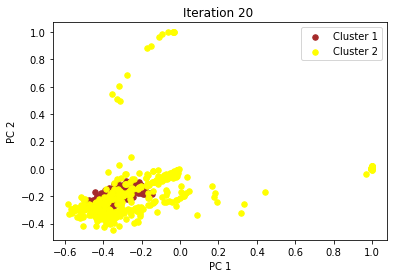

[9703.074509802558, 10786.590300857226, 11061.818084849454, 11200.263746224236, 11289.959239822416, 11336.620755658414, 11366.43259591408, 11386.675945183822, 11399.826165823799, 11414.4654116063, 11423.7923288307, 11436.159611402265, 11458.983622326814, 11480.981160384908, 11485.541623070389, 11486.338627867297, 11486.73444569902, 11486.932762639488, 11487.016498817919, 11487.05095840099]


In [116]:
                 # Likelihood for initial values

count=1
LL_values=[]                                                   

while (count<21):
    old_Z=Z.copy()
    LL=likelihood(final_data, Z, alpha, mean, sigma)
    
    LL_values.append( LL)    
    scatter_plot(Z,count)                                       
    
    Z= E_step(alpha,mean,sigma)                             
    alpha, mean, sigma  = M_step(Z) 
#     if(old_Z==Z).all():
#         break

    count+=1
   
print(LL_values)   

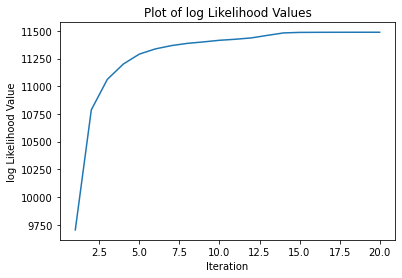

In [117]:
plt.plot([i for i in range(1,21)],LL_values)
plt.xlabel('Iteration')
plt.ylabel('log Likelihood Value')
plt.title('Plot of log Likelihood Values')
plt.show()

# accuracy of EM clustering algo

In [118]:
count =0
cluster = np.zeros((N,1))

for i in range(N):
    
    if Z[i][1] > Z[i][0]:
        cluster[i] = 1
    
    if cluster[i] == Label[i]:
            count += 1

accuracy = (count/N) * 100

print(accuracy)

55.400000000000006


# observation
On initialization by randomly assigning values accuracy ranges between  43.0% to 58%. 
With K mean initialisation as well, it is coming around the same. In the last case it came 
55.80%.

diagonal matrix decreases computaional cost and in above case it is giving around
same performance as given by non diagonal covariance matrix

since there are only 1000 data points.. the computation was faster whereas in QSN 3d 
it was hard to handle Large number of data points which led to computation inaccuracy a lot 
of time.